<a href="https://colab.research.google.com/github/Sounak123/MachineLearingDemo-Diabetes/blob/main/wine_review_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [9]:
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [10]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [11]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


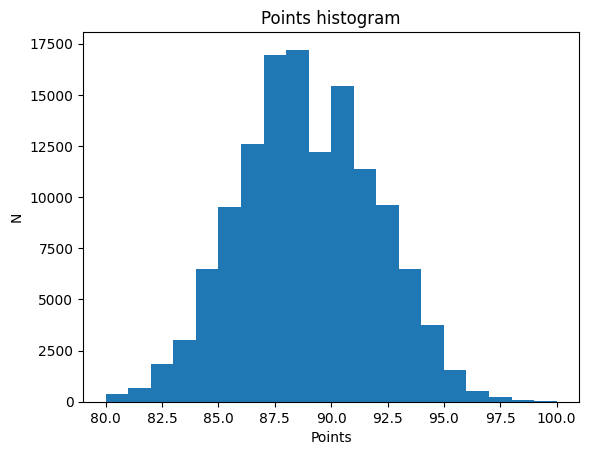

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [12]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]

In [14]:
df.tail()

,description,points,label
129966,Notes of honeysuckle and cantaloupe sweeten th...,90,1
129967,Citation is given as much as a decade of bottl...,90,1
129968,Well-drained gravel soil gives this wine its c...,90,1
129969,"A dry style of Pinot Gris, this is crisp with ...",90,1
129970,"Big, rich and off-dry, this is powered by inte...",90,1


In [15]:
df = df[["description", "label"]]

In [16]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [17]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [18]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [19]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [20]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'A co-fermented field blend from vineyards dating back more than 125 years, this heritage red has 13% Alicante Bouschet and 7% Petite Sirah in addition to 2% of a range of grapes, from Tannat to Muscat Noir. Milk chocolate, black pepper and soft black fruit mingle on the medium-bodied palate, with a lingering streak of cinnamon and vanilla on the finish.',
        b"This lean, simple white offers yellow flower, citrus zest and grilled herb flavors. It's bright, with a clean finish.",
        b"This shows a delicate silkiness and a sweet essence of wild raspberries that make it fully ready to drink now. But that quality obscures its subtleties of mineral, mushroomy earth and flower notes that add to this Pinot's great complexity. As good as it is now, it will have no trouble negotiating the next decade.",
        ...,
        b"Fragrant and refined, this elegant wine offers aromas of ripe berry, crushed flower and forest floor. T

# Embedding + Model

In [34]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [35]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.37104636,  0.00553003,  0.05761776, ..., -0.2148634 ,
        -0.09043164, -0.00148573],
       [ 0.57261544, -0.4277183 , -0.16621698, ...,  0.0421401 ,
         0.03732223, -0.14403586],
       [ 0.32135212, -0.1538995 , -0.03359704, ..., -0.17483231,
        -0.20192263,  0.2686089 ],
       ...,
       [ 0.36304954, -0.18537407,  0.05670585, ..., -0.05567682,
        -0.14862363, -0.10680018],
       [ 0.4750453 , -0.02907177, -0.12076788, ..., -0.01542831,
        -0.18296076,  0.16907395],
       [ 0.3535367 , -0.02867074,  0.05869676, ..., -0.01930722,
        -0.11737341,  0.21389182]], dtype=float32)>

In [36]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) #Improve on validation acc and validation loss
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4)) #Improve on validation acc and validation loss
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [37]:
#Add an Optimizer to the model(Its like a bias probability algorithm)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [38]:
model.evaluate(train_data)

102/102 [==============================] - 2s 15ms/step - loss: 0.6994 - accuracy: 0.4441


[0.6993645429611206, 0.4441409409046173]

In [39]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 9ms/step - loss: 0.6992 - accuracy: 0.4490


[0.6992112994194031, 0.4490267038345337]

In [30]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 83s 801ms/step - loss: 0.5436 - accuracy: 0.7117 - val_loss: 0.4209 - val_accuracy: 0.8003
Epoch 2/10
102/102 [==============================] - 70s 687ms/step - loss: 0.3736 - accuracy: 0.8288 - val_loss: 0.3784 - val_accuracy: 0.8229
Epoch 3/10
102/102 [==============================] - 71s 690ms/step - loss: 0.3307 - accuracy: 0.8540 - val_loss: 0.3715 - val_accuracy: 0.8280
Epoch 4/10
102/102 [==============================] - 70s 686ms/step - loss: 0.3055 - accuracy: 0.8670 - val_loss: 0.3727 - val_accuracy: 0.8270
Epoch 5/10
102/102 [==============================] - 70s 684ms/step - loss: 0.2871 - accuracy: 0.8764 - val_loss: 0.3756 - val_accuracy: 0.8278
Epoch 6/10
102/102 [==============================] - 70s 682ms/step - loss: 0.2704 - accuracy: 0.8851 - val_loss: 0.3821 - val_accuracy: 0.8286
Epoch 7/10
102/102 [==============================] - 69s 674ms/step - loss: 0.2556 - accuracy: 0.8931 - val_loss: 0.3888 - val_ac

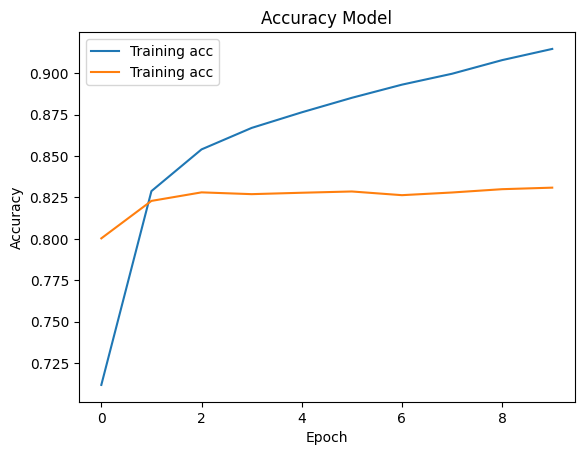

In [31]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy Model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

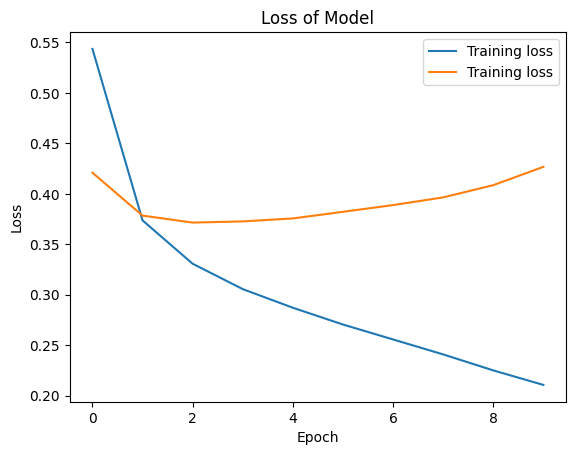

In [32]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title("Loss of Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [40]:
# after adding dropout layer
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 63s 605ms/step - loss: 0.6203 - accuracy: 0.6417 - val_loss: 0.4913 - val_accuracy: 0.7803
Epoch 2/5
102/102 [==============================] - 63s 617ms/step - loss: 0.4631 - accuracy: 0.7862 - val_loss: 0.3999 - val_accuracy: 0.8113
Epoch 3/5
102/102 [==============================] - 63s 619ms/step - loss: 0.3966 - accuracy: 0.8286 - val_loss: 0.3806 - val_accuracy: 0.8192
Epoch 4/5
102/102 [==============================] - 62s 605ms/step - loss: 0.3625 - accuracy: 0.8452 - val_loss: 0.3776 - val_accuracy: 0.8246
Epoch 5/5
102/102 [==============================] - 62s 604ms/step - loss: 0.3402 - accuracy: 0.8559 - val_loss: 0.3785 - val_accuracy: 0.8271


In [41]:
model.evaluate(test_data)

13/13 [==============================] - 1s 84ms/step - loss: 0.3688 - accuracy: 0.8361


[0.36875641345977783, 0.8361286520957947]

# LSTM: Long Short-term Memory

In [43]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [44]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [45]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [47]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 1s 98ms/step - loss: 0.6938 - accuracy: 0.4431


[0.6938480734825134, 0.44310224056243896]

In [48]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 33s 289ms/step - loss: 0.5368 - accuracy: 0.7178 - val_loss: 0.3980 - val_accuracy: 0.8156
Epoch 2/5
102/102 [==============================] - 30s 289ms/step - loss: 0.3678 - accuracy: 0.8357 - val_loss: 0.3533 - val_accuracy: 0.8377
Epoch 3/5
102/102 [==============================] - 29s 281ms/step - loss: 0.3477 - accuracy: 0.8459 - val_loss: 0.3501 - val_accuracy: 0.8409
Epoch 4/5
102/102 [==============================] - 30s 287ms/step - loss: 0.3410 - accuracy: 0.8487 - val_loss: 0.3638 - val_accuracy: 0.8359
Epoch 5/5
102/102 [==============================] - 29s 283ms/step - loss: 0.3385 - accuracy: 0.8499 - val_loss: 0.3518 - val_accuracy: 0.8376


In [49]:
model.evaluate(test_data)

13/13 [==============================] - 2s 111ms/step - loss: 0.3451 - accuracy: 0.8444


[0.34514421224594116, 0.8444375991821289]